In [19]:
import cv2
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import re
import pandas as pd

In [21]:
train_labels=["Trash", "Clean"]
df=pd.read_csv('Val/TrashValidation.csv')
df=df.loc[:,["Filenames","Trash","Clean"]]
df.head()

,Filenames,Trash,Clean
0,Basura1.jpg,1,0
1,Basura2.jpg,1,0
2,Basura3.jpg,1,0
3,Basura4.jpg,1,0
4,Basura5.jpg,1,0


In [24]:
train_datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)


train_generator=train_datagen.flow_from_dataframe(
dataframe=df.sample(n=120, random_state=42),
directory="train",
x_col="Filenames",
y_col=train_labels, #array previously created
batch_size=16,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(64,64))

valid_generator=test_datagen.flow_from_dataframe(
dataframe=df.sample(n=20, random_state=42),
directory="train",
x_col="Filenames",
y_col=train_labels,
batch_size=8,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(64,64))

test_generator=test_datagen.flow_from_dataframe(
dataframe=df.sample(n=20, random_state=42),
directory="train",
x_col="Filenames",
batch_size=16,
seed=42,
shuffle=True,
class_mode=None,
target_size=(64,64))

Found 120 validated image filenames.
Found 20 validated image filenames.
Found 20 validated image filenames.


In [25]:
#Additional libraries
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import regularizers, optimizers, Sequential

In [57]:
first_batch = next(train_generator)
print(first_batch[0].shape)

(16, 64, 64, 3)


In [65]:
#Input of the network
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same',
                 input_shape=(64,64,3)))
#padding='same|valid->zero padding, no padding'
model.add(Activation('relu'))

In [66]:
#Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))

#Pooling Layer
model.add(MaxPooling2D(pool_size=(2, 2))) #Add a MaxPooling Layer with a size of 2x2
model.add(Dropout(0.25))                  #It Shuts down the 25% of the unities during the training
model.add(Flatten())

#Fully connected
model.add(Dense(50))                     #Neuronal layer of 512 neurons that has an activation function ReLu with a Dropout of 0.5
model.add(Activation('relu'))
model.add(Dropout(0.5))

#Output layer, this depends on the number of classes,
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 50)                  │       1,638,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,648,696 (6.29 MB)

 Trainable params: 1,648,696 (6.29 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
#Update
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [79]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size #3500/16 =  218.75
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size #650/ 8  =  81.25
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size    #650/ 16 =  40.625
EPOCHS = 2
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS
)

Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.6259 - loss: 0.6152 - val_accuracy: 0.4375 - val_loss: 0.6541
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6250 - loss: 0.6047 - val_accuracy: 0.7500 - val_loss: 0.5864


Text(0.5, 1.0, 'Val_accuracy & Accuracy Diagram')

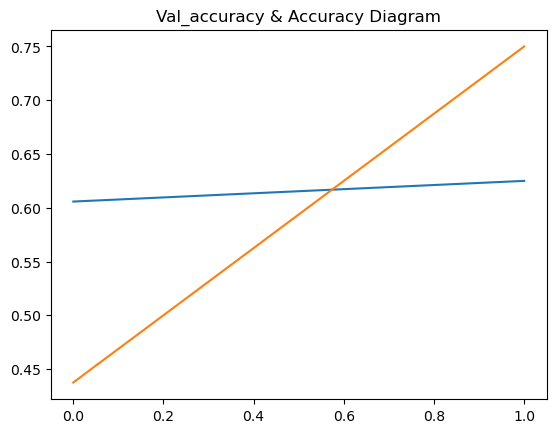

In [80]:
#plot learning curves
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Val_accuracy & Accuracy Diagram')

In [81]:
model.save('model2.keras')

In [82]:
from tensorflow.keras.models import load_model
model = load_model('model2.keras')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


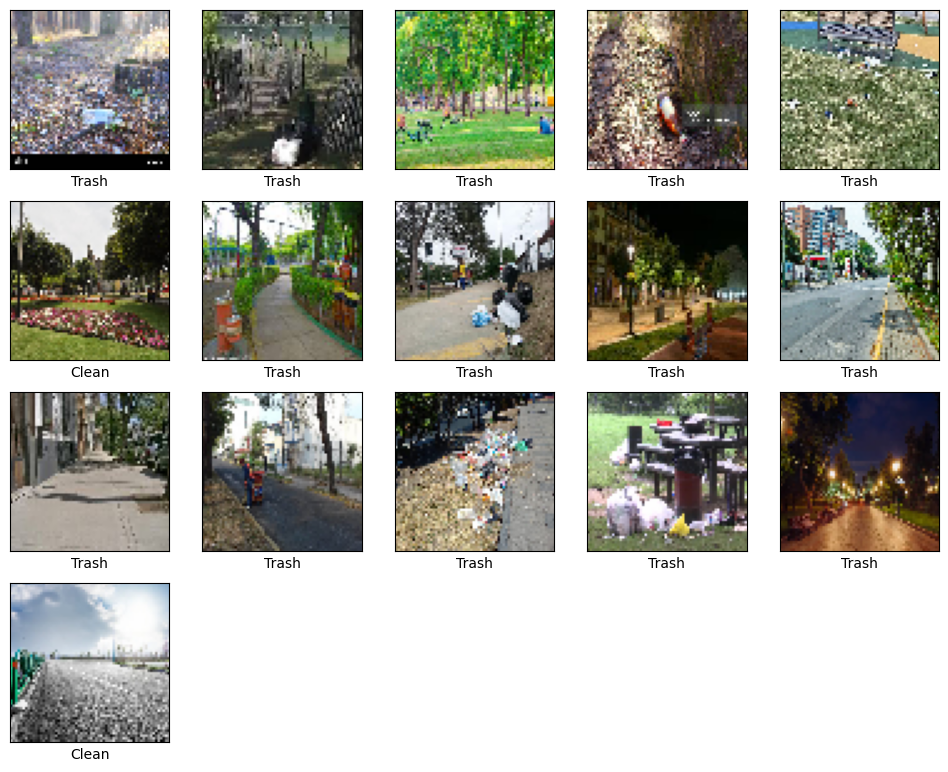

In [83]:
test_generator.reset()
STEP_SIZE_TEST = len(test_generator)
pred = model.predict(test_generator, steps=STEP_SIZE_TEST, verbose=1)
#We obtain a probability vector (2-dimensional) for each test image
#print(pred.shape)
#print(pred)
columns=["Trash","Clean"]
plt.figure(figsize=(12,12))

#Range of images to show
num_images = min(len(test_generator[0]), 25) # Limita el número de imágenes a mostrar a 25 o la longitud del generador si es menor,
                                             # esto debido a un error del código anterior que no dejaba mostrar más de 6 imágenes
for i in range(num_images):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_generator[0][i])
    plt.xlabel(columns[np.argmax(pred[i])])  # Uses the model´s predictions
plt.show()

In [94]:
pred_bool = (pred >0.5)
predictions = pred_bool.astype(int)
columns=["Trash","Clean"]

#columns should be the same order of y_col
results=pd.DataFrame(predictions, columns=columns)
results["Filenames"]=test_generator.filenames[:640]
ordered_cols=["Filenames"]+columns
results=results[ordered_cols]                      #To get the same column order
results

,Filenames,Trash,Clean
0,Basura106.jpg,1,0
1,Basura109.jpg,1,0
2,Basura142.jpg,1,0
3,Basura56.jpg,1,0
4,Basura95.jpg,1,0
5,Basura30.jpg,0,1
6,Basura102.jpg,1,0
7,Basura52.jpg,1,0
8,Basura101.jpg,1,0
9,Basura143.jpg,1,0
